# Homework nr. 1 - data visualization (deadline 25/10/2018)

In short, the main task is to download data on theses defended at CTU from the Internet, store them in pandas Data Frame and then visualize some hidden information.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can. Thinking of how to visualize the data is an important part of data visualization! ;)

## What are you supposed to do:

  1. Browse the web https://dspace.cvut.cz/?locale-attribute=en and find out how to download data on Bachelor and Master theses.
  2. Download or scrape the data such that for each thesis you know the following:
    * Faculty name, department name, thesis title, thesis type (bachelor/master), supervisor name, reviewer name, year (or date) of the defence, study programme and discipline, link to a webpage with details.
  3. Store these data in one _csv_ file (should be handed in along with this notebook).
  4. Use tools available for Python to plot charts and tables to visualize/display this information:
    * Number of defended theses per year for CTU/Faculties. Distinguish the type of thesis.
    * Find the departments/study programmes/supervisors/reviewers with highest numbers of thesis and come up with some nice plots and tables to depict their numbers.
    * Mean/median/minimum/maximum number of supervised theses per year for faculties.
    * Number (or fraction) of theses supervised by people with various degrees (Bc./Ing./Ph.D./ ...).

**If you do all this properly, you will obtain 6 points**

To earn **extra two points** you can do some of these:
  * Use http://beakerx.com to make your notebook interactive in a meaningful way.
  * Come up with some other reasonable and interesting views of data.
  * Use your data to create an interactive webpage (HTML + JavaScript).

## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, he can give you another chance to rework your homework and to obtain more points.

## Solution 

### Data downloading
* Data are download from page dspace, where can be list all uploaded work on CTU.
* Data for each work can be download as table on work url (https://dspace.cvut.cz/handle/10467/78315?show=full)
* Data jsou ve více jazycích. To upřednostňuje jazyk spolu se staženými soubory (bachelor, master's, ...), lze specifikovat.
* In script I download master's and bachelor's thesis and want data in english if possible.
* In data table are not save faculty name and people's degrees.
* Faculty name are parse from page navigation in every work own page.
* Degree for supervisors and rereviewers can be dowload from (https://usermap.cvut.cz/)
    * There is some problems. UserMap are genereted by js script and can't be dowload by html get.
    * So, for download degrees of supervisor and rereviewers need selenium and Chrome driver for generating pages. This generating pages take some time. For this reason, I have enclosed the csv file with downloaded data.
* While downloading are data flush to csv every downloaded page with works. This prevent lost data when run raise exception.
* Data are save in works.csv with head of csv 
(,supervisor,author,uri,language,subject,title,type,acceptedDate,
rewiever,discipline,department,programme,faculty,supervisor_degree,rewiever_degree)




In [8]:
# Imports for downloading

import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
import os.path


In [9]:
from selenium import webdriver
# Problem when getting people from users.cvut.cz Ajax rendering. 
# For get people -> need Chrome webdriver and it is take more time to get All
# Function to get degrees of people 
class People():
    
    def __init__(self):
        self.driver = webdriver.Chrome()
        self.people = {}
    
    def end(self):
        self.driver.quit()
        
    "Get degree from user whichc work on faculty. Cache users for not download mre tha one."
    def getDegree(self, name, faculty):
        try:
            item = (name, faculty)
            if item in self.people:
                return self.people[item]
            
            self.driver.get("https://usermap.cvut.cz/search?query=" + name);
            for element in self.driver.find_elements_by_id(
                "search-results-table")[0].find_element_by_tag_name(
                "tbody").find_elements_by_tag_name("tr"):
            
                names = element.find_element_by_tag_name("a").text
                fac = element.find_element_by_tag_name("abbr").get_attribute("title").split("-")[0].strip()
                if faculty == fac:
                    splitName = names.split(",")
                    degrees = ", ".join(splitName[len(name.split(" ")):])
                    self.people[(name, faculty)] = degrees
                    return degrees
        except Exception:
            return None
        return None
        
    
    

In [ ]:
# Download data - It may take a several minutes. 
#                 You can edit the number of pages downloaded. 
#                 Work is being rolled down from the newest.


# Main dpace url for find BP, DP
urlMain = 'https://dspace.cvut.cz{}'
# Url with search form
urlDist = '/discover' 
# Data for specific page to download
data = {
    'rpp' : '100',
    'etal' : '0', 
    'group_by' : 'none', 
    'page' : '0',
    'sort_by' : 'dc.date.issued_dt',
    'order' : 'desc'}

#Prefered lang
pref_lang = "eng"
#Download degrees from usemap -> need chrome driver for render javascript to download.
dPeople = True
work_get = {"bachelor thesis", "master's thesis", 'bakalářská práce', 'diplomová práce'}

# Need
newColumns = {'dc.contributor.advisor' : 'supervisor' , 'dc.contributor.author' : 'author', 
                 'dc.identifier.uri' : 'uri', 'dc.date.issued' : 'issued',
       'dc.language.iso' : 'language', 'dc.subject' : 'subject', 'dc.title' : 'title', 'dc.type' : 'type',
       'dc.date.accepted' : 'acceptedDate', 'dc.contributor.referee' :'rewiever',
       'theses.degree.discipline' : 'discipline', 'theses.degree.grantor' : 'department',
       'theses.degree.programme' : 'programme'}

if dPeople: people = People()
# Group columns by language spec and keep one of want language or if not exist keep another one.
# Keep only one column in prefer language
def manageColumns(df):
    mp={}
    rem_flag = False
    for number, lang in enumerate(df[2]):
        if df[0][number] not in mp:
            mp[df[0][number]] = []
        mp[df[0][number]].append((lang, number))
    for i in mp.copy():
        if len(mp[i])> 1:
            for j in mp[i]:
                if j[0] == pref_lang:
                    mp[i].remove(j)
                    rem_flag = True
                    break
            if not rem_flag:
                mp[i].pop(0)
        else:
            del mp[i]
    for i in mp:
        for j in mp[i]:
            df = df.drop(j[1], axis=0)
    return df

# Extract nice data frame from one work html page to table
def parseDataFromHtmlTablePage(pageText):
    ldf = pd.read_html(pageText.text,header = None, flavor = 'bs4')
    df = ldf[0]
    df = manageColumns(df)
    df = df.transpose()
    df.columns = df.iloc[0]
    if ("dc.type" not in df.columns):
        print("Not specific type.")
        return pd.DataFrame()
    df = df.drop(0, axis = 0)
    df = df.drop(2, axis = 0)
   
    if (str(df['dc.type'][1]).lower() not in work_get):
        return pd.DataFrame()
    
    for i in newColumns:
        if i not in df.columns:
            df[i]=None
    for i in df.columns:
        if i not in newColumns:
            df = df.drop(i, axis=1)
    
    df.rename(columns=newColumns, inplace=True)
   
    # Data which are not on dspace page
    df["faculty"] = BeautifulSoup(pageText.text, "html.parser").find_all("ul", 
                        {"class": "breadcrumb hidden-xs"})[0].find_all("li")[1].get_text().strip()
    if dPeople:
        try:
            df["supervisor_degree"] = people.getDegree(df['supervisor'][1], df['faculty'][1]) 
        except Exception:
            df["supervisor_degree"] = None
        try:
            df["rewiever_degree"] = people.getDegree(df['rewiever'][1], df['faculty'][1])
        except Exception:
            df["rewiever_degree"] = None
    return df

# Data frame with all data
data_all = pd.DataFrame(columns = ['supervisor', 'author', 'issued', 'uri', 'language', 'subject', 'title', 'type', 
                  'acceptedDate', 'rewiever', 'discipline', 'department', 
                                   'programme', 'faculty', 'supervisor_degree', 'rewiever_degree'])

firstPage = requests.get(urlMain.format(urlDist), data)
soup = BeautifulSoup(firstPage.text, "html.parser")
pages = int(soup.find("li", {"class": "last-page-link"}).find("a").get_text())
print("Download first page. Pages with works:", pages, flush=True)

sumTime = 0
file = 'tmp.csv'
# from page
fromPage = 150
# go over all pages
for pg in range(fromPage, pages+1):

    data['page'] = pg
    page = requests.get(urlMain.format(urlDist), data)
    soup = BeautifulSoup(page.text, "html.parser")
    
    # go over all items on page
    t1 = time.time()
    for i in soup.findAll("div", {"class": "row ds-artifact-item "}):
        one = requests.get(urlMain.format(i.find("a").get("href")), {'show' : 'full'})
        if one.status_code != 200:
            print("Cant reach the work page. Continue..")
            continue
        
        df = parseDataFromHtmlTablePage(one)
        if df.shape[0] == 0:
            continue
        if data_all.shape[0] == 0:
            data_all = df.copy()
        else:
            data_all = pd.concat([data_all,df], ignore_index=True, sort=False)
        
    if data_all.shape[0] == 0:
            continue
    # Get lower type and convert date in Data Frame
    data_all['type'] = data_all['type'].str.lower()
    
    #data_all['acceptedDate'] =  pd.to_datetime(data_all['acceptedDate'], format='%Y-%m-%d')
    
    #Count time and print download pages. 
    #After 100 download flush dataframe to csv. 
    #To prevent program die.
    sumTime += time.time()-t1
    
    print("Page:", pg, "/", pages, flush=True)
    print(sumTime, pg, flush=True)
    if os.path.isfile(file):
        data_all = data_all.reindex(sorted(data_all.columns), axis=1)
        data_all.to_csv(file, mode='a', sep=',', header=False)
    else:
        data_all = data_all.reindex(sorted(data_all.columns), axis=1)
        data_all.to_csv(file, mode='a', sep=',', header=True)
        
    data_all = data_all.iloc[0:0]
       
    print("Remaining :", (sumTime/(pg+1-fromPage))*(pages-pg), flush=True)
    
if dPeople: people.end()



### Data visualize
The data visualization is divided into 4 parts, according to the input

#### The first shows the number of defended works at each faculty in each year. 
* I've seen the data in the table and using a grouped chart bar. 
* Individual data and columns may not match the exact reality because many thesis do not have all the data on DSpace. 
* For example, the date of the defense is missing, but on some more detailed findings, some of these thesis in the faculties have been defended.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skit
import seaborn as sns
from IPython.display import display, Markdown, Latex

RAW_DATA = pd.read_csv('test3.csv', index_col=0).reset_index(drop=True)
RAW_DATA['acceptedDate'] =  pd.to_datetime(RAW_DATA['acceptedDate'], format='%Y-%m-%d')
RAW_DATA['issued'] =  pd.to_datetime(RAW_DATA['issued'], format='%Y-%m-%d')
RAW_DATA['year'] = RAW_DATA['acceptedDate'].map(lambda x: x.year)

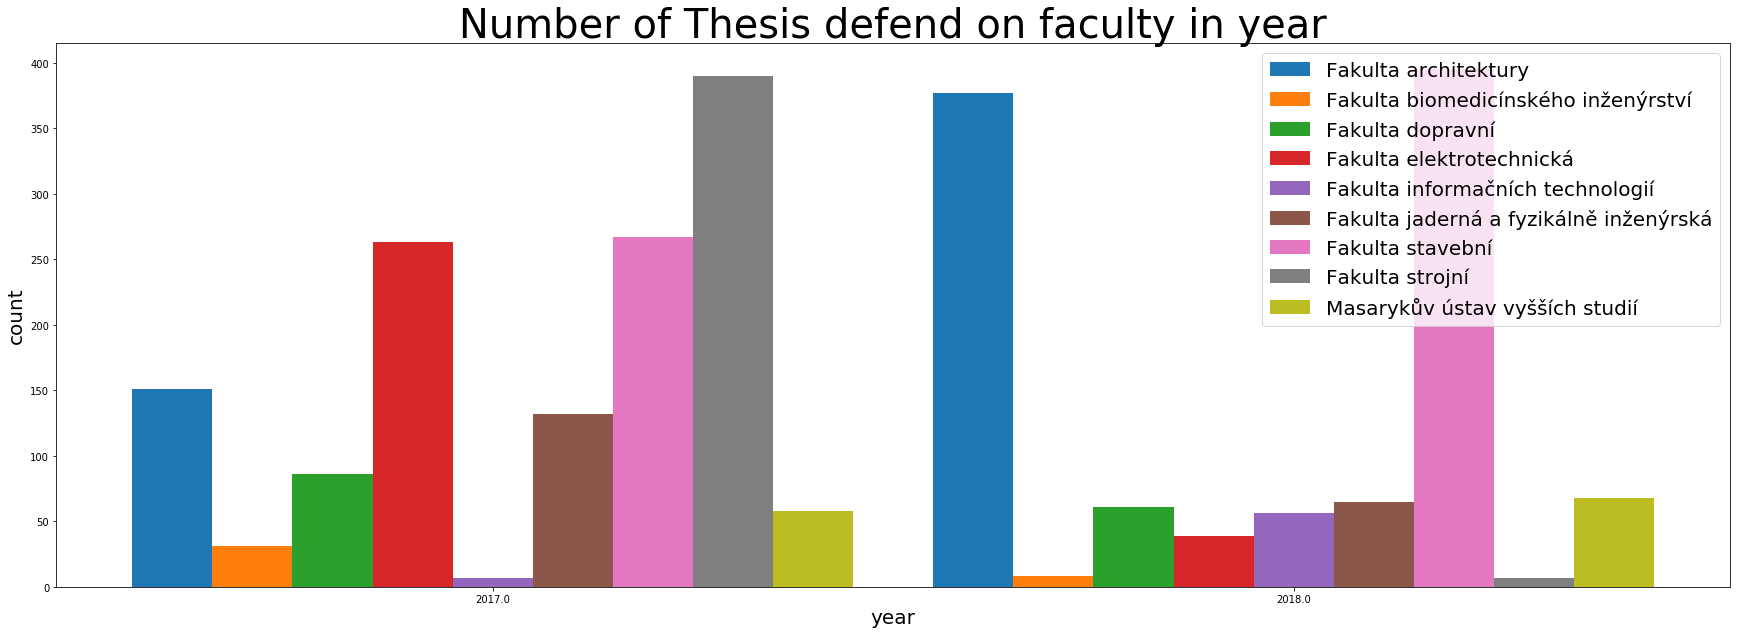

,year,faculty,count
17,2017.0,Fakulta informačních technologií,7
5,2017.0,Fakulta architektury,151
1,2017.0,Fakulta strojní,390
14,2017.0,Fakulta biomedicínského inženýrství,31
7,2017.0,Fakulta dopravní,86
4,2017.0,Fakulta elektrotechnická,263
3,2017.0,Fakulta stavební,267
11,2017.0,Masarykův ústav vyšších studií,58
6,2017.0,Fakulta jaderná a fyzikálně inženýrská,132
16,2018.0,Fakulta strojní,7


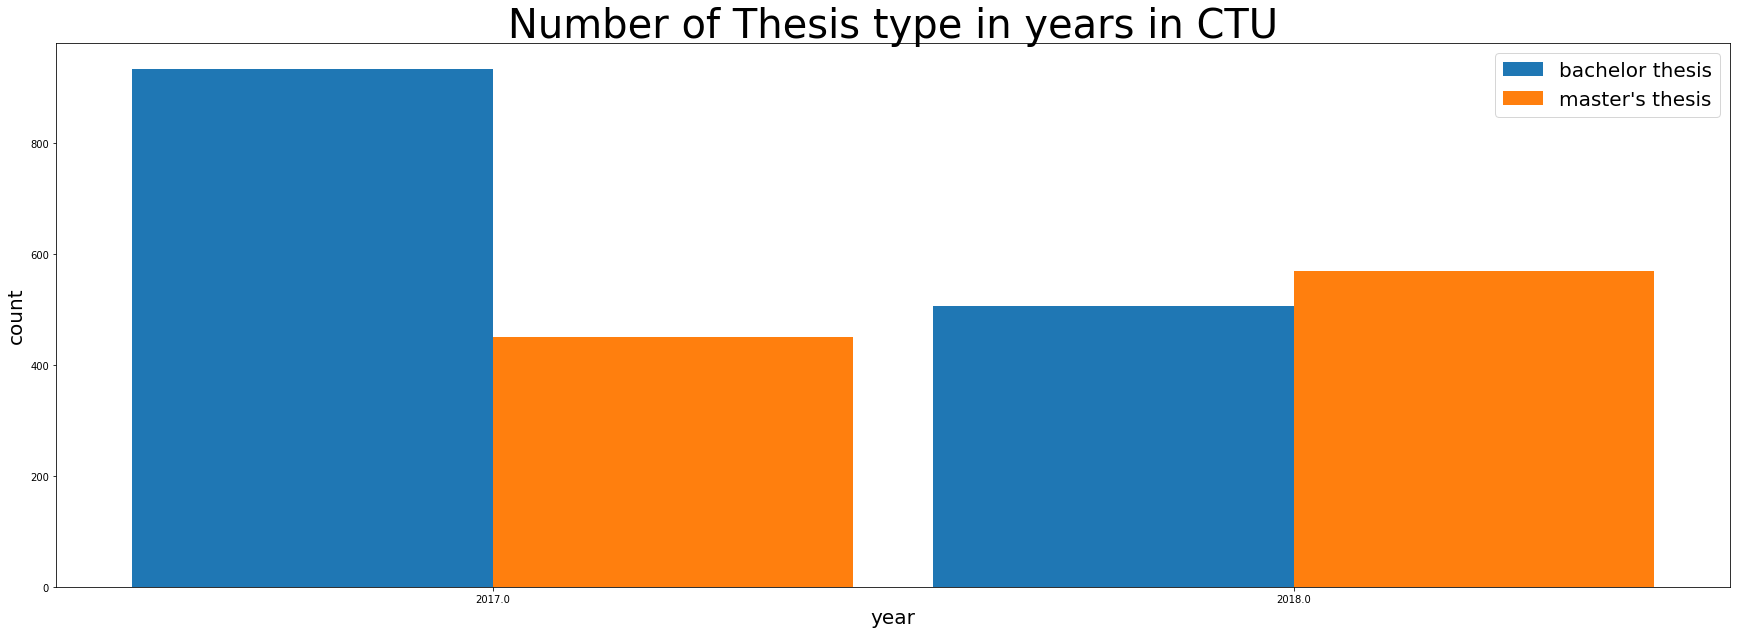

,year,type,count
0,2017.0,bachelor thesis,934
3,2017.0,master's thesis,451
2,2018.0,bachelor thesis,506
1,2018.0,master's thesis,570


#### Number of thesis defend on faculty, diveded into master and bachelor.

,faculty,type,count
5,Fakulta architektury,master's thesis,359
6,Fakulta architektury,bachelor thesis,308
16,Fakulta biomedicínského inženýrství,master's thesis,24
17,Fakulta biomedicínského inženýrství,bachelor thesis,15
12,Fakulta dopravní,bachelor thesis,117
10,Fakulta dopravní,master's thesis,198
2,Fakulta elektrotechnická,bachelor thesis,498
3,Fakulta elektrotechnická,master's thesis,489
8,Fakulta informačních technologií,bachelor thesis,266
11,Fakulta informačních technologií,master's thesis,145


In [3]:
dataCVUT = RAW_DATA.copy()
#group by year and faculty

def groupedBoxPlot(boxLb, xLb, ttl):
    df1 = pd.DataFrame({'count' : dataCVUT.groupby([xLb, boxLb
                                    ]).size().sort_values(ascending=False)}).reset_index()
    
    #create subplots
    fig, ax = plt.subplots(figsize=(30,10))
    plt.ylabel("count")
    plt.xlabel(xLb)
    plt.rc('axes',labelsize=20, titlesize=30)
    #x 
    ind = sorted(df1[xLb].unique())
    #bar
    fac = sorted(df1[boxLb].unique())

    magicNumber = float(0.90/len(fac)) # the width of the bars
    startNumber = float(-1*(0.90/2)) #distribute bars near the year

    pp = []
    for f in fac:
        # Get data by faculty
        df = df1.loc[df1[boxLb] == f, [xLb, 'count']].sort_values(by = xLb, ascending=True)
        # Add year which are not in faculty. Fill with 0
        for yr in ind:
            if yr not in df[xLb].tolist():
                df = df.append(pd.DataFrame([[yr, 0]], columns=[xLb, 'count']), ignore_index=True)
        # List from sorted years with count
        df = df.sort_values(by = xLb, ascending=True)["count"].tolist()
        # Create bars shifted by number which distributed around the year
        pp.append(ax.bar([x+startNumber+magicNumber/2 for x in ind], df, magicNumber))
        startNumber += magicNumber

    ax.set_title(ttl, size = 40)
    ax.set_xticks([x for x in ind])
    ax.set_xticklabels(ind)
    
    ax.legend([x[0] for x in pp], fac, fontsize = 20)
    ax.autoscale_view()
    plt.show()
    display(df1.sort_values(by=boxLb).sort_values(by=xLb))
    
groupedBoxPlot('faculty', 'year', 'Number of Thesis defend on faculty in year')
groupedBoxPlot('type', 'year', 'Number of Thesis type in years in CTU')
display(Markdown('#### Number of thesis defend on faculty, diveded into master and bachelor.'))
boxLb = 'type'
xLb = 'faculty'
df1 = pd.DataFrame({'count' : dataCVUT.groupby([xLb, boxLb]).size().sort_values(ascending=False)}).reset_index()
display(df1.sort_values(by=boxLb).sort_values(by=xLb))

In [3]:
dataCVUT = RAW_DATA.copy()
df1 = pd.DataFrame({'count' : dataCVUT.groupby(['year', 'faculty'
                                ]).size().sort_values(ascending=False)}).reset_index()

years = sorted(df1['year'].unique())
facs = sorted(df1['faculty'].unique())
data = pd.DataFrame(columns = sorted(df1['faculty'].unique()))
for y in years:
    tmp = df1.loc[df1['year'] == y, ['faculty', 'count']].sort_values(by = 'faculty', ascending=True)
    tmp.index = tmp['faculty']
    tmp = tmp.drop('faculty', axis=1).transpose()
    tmp.index = [y]
    data = pd.concat([data,tmp], sort=False)
    
for f in facs:
    data[f]  = pd.to_numeric(data[f], errors='ignore')

display(Markdown('#### Mean/median(50%)/minimum/maximum number of supervised theses per year for faculties.'))
display(data.transpose().reindex(sorted(years), axis=1).describe().loc[['mean', '50%', 'min', 'max']])

#### Mean/median(50%)/minimum/maximum number of supervised theses per year for faculties.

,2017.0,2018.0
mean,153.888889,119.555556
50%,132.000000,61.000000
min,7.000000,7.000000
max,390.000000,395.000000


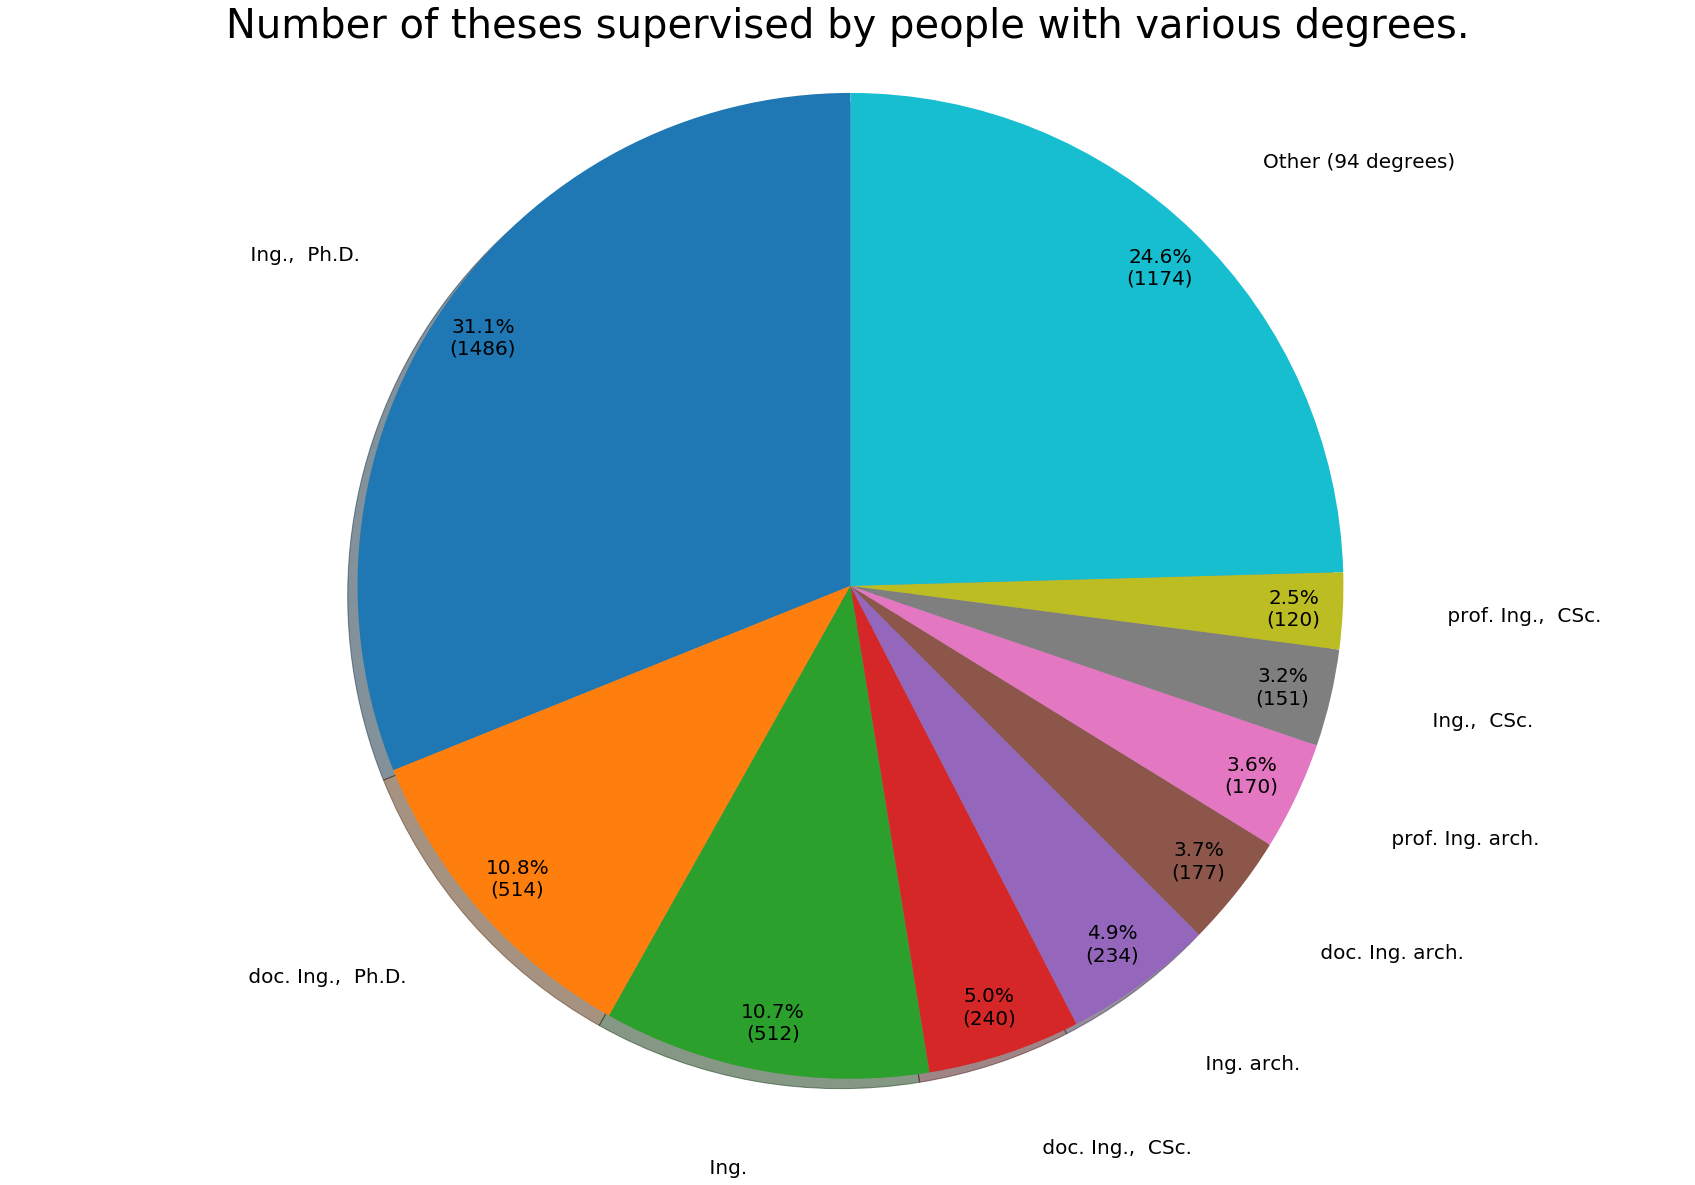

In [4]:
dataCVUT = RAW_DATA.copy()

degrees = 8
df1 = pd.DataFrame({'count' : dataCVUT.groupby(['supervisor_degree']).size().sort_values(ascending=False)}).reset_index()
tmp = df1.loc[degrees:,:].sum()
tmp['supervisor_degree'] = "Other (" + str(df1.loc[:,:].count()['count']) + " degrees)"
df1 = pd.concat([df1.loc[:degrees,:],pd.DataFrame(tmp).transpose()], sort=False)

labels = df1['supervisor_degree']
sizes = df1['count']

explode = [0] * len(labels) 

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

fig1, ax1 = plt.subplots(figsize=(30,20))
ax1.pie(sizes, explode=explode, labels=labels, autopct=lambda pct: func(pct, sizes),
        shadow=True, startangle=90, textprops={'fontsize': 20}, pctdistance=0.9, labeldistance=1.2)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Number of theses supervised by people with various degrees.", size = 40)
plt.rc('axes',labelsize=20, titlesize=30)
plt.show()
